# CNN Explaination

[作業說明投影片](https://docs.google.com/presentation/d/1VClvgyilAvohextY0tM3gD7YemXGSUrzLV0E8RjDnMU/edit?usp=sharing)

如果有自己的計算資源，不想使用 colab 的話，可以參考純 [Python script](https://github.com/leo19941227/MLHW4-Explainable) 的版本

若有任何問題，歡迎來信至助教信箱： ntu-ml-2020spring-ta@googlegroups.com

## Environment settings

In [0]:
# 下載並解壓縮訓練資料
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/food-11.zip
1.16GB [00:05, 212MB/s]
Archive:  food-11.zip
replace food-11/testing/0071.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# 下載 pretrained model，這裡是用助教的 model demo，寫作業時要換成自己的 model
!gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu
To: /content/checkpoint.pth
170MB [00:03, 53.0MB/s]


In [0]:
# 安裝lime套件
# 這份作業會用到的套件大部分 colab 都有安裝了，只有 lime 需要額外安裝
!pip install lime==0.1.1.37

     |████████████████████████████████| 276kB 6.7MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=0a9157137b38fd458093e32ad767a7189d8412db525040ef4f15e53213ede296
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=d9fa5d8e1543ac64fa8e78b978c68d528946e508107449bf4523a15bc9897e92
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


## Start our python script

In [0]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

## Argument parsing

In [0]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

## Model definition and checkpoint loading

In [0]:
# 這是助教的示範 model，寫作業時一樣要換成自己的
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [0]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# 基本上出現 <All keys matched successfully> 就是有載入成功，但最好還是做一下 inference 確認 test accuracy 沒有錯。

<All keys matched successfully>

## Dataset definition and creation

In [0]:
# 助教 training 時定義的 dataset
# 因為 training 的時候助教有使用底下那些 transforms，所以 testing 時也要讓 test data 使用同樣的 transform
# dataset 這部分的 code 基本上不應該出現在你的作業裡，你應該使用自己當初 train HW3 時的 preprocessing
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # 這個 FoodDataset 繼承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定義一個 pytorch dataset 時一定要 implement 的兩個 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 這個 method 並不是 pytorch dataset 必要，只是方便未來我們想要指定「取哪幾張圖片」出來當作一個 batch 來 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# 給予 data 的路徑，回傳每一張圖片的「路徑」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 這邊在 initialize dataset 時只丟「路徑」和「class」，之後要從 dataset 取資料時
# dataset 的 __getitem__ method 才會動態的去 load 每個路徑對應的圖片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start Homework 4

### Saliency map

我們把一張圖片丟進 model，forward 後與 label 計算出 loss。
因此與 loss 相關的有:
- image
- model parameter
- label

通常的情況下，我們想要改變 model parameter 來 fit image 和 label。因此 loss 在計算 backward 時我們只在乎 **loss 對 model parameter** 的偏微分值。但數學上 image 本身也是 continuous tensor，我們可以計算  **loss 對 image** 的偏微分值。這個偏微分值代表「在 model parameter 和 label 都固定下，稍微改變 image 的某個 pixel value 會對 loss 產生什麼變化」。人們習慣把這個變化的劇烈程度解讀成該 pixel 的重要性 (每個 pixel 都有自己的偏微分值)。因此把同一張圖中，loss 對每個 pixel 的偏微分值畫出來，就可以看出該圖中哪些位置是 model 在判斷時的重要依據。

實作上非常簡單，過去我們都是 forward 後算出 loss，然後進行 backward。而這個 backward，pytorch 預設是計算 **loss 對 model parameter** 的偏微分值，因此我們只需要用一行 code 額外告知 pytorch，**image** 也是要算偏微分的對象之一。

In [0]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 最關鍵的一行 code
  # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
  # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
  x.requires_grad_()
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  saliencies = x.grad.abs().detach().cpu()
  # saliencies: (batches, channels, height, weight)
  # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
  # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
  # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
  # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
  # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

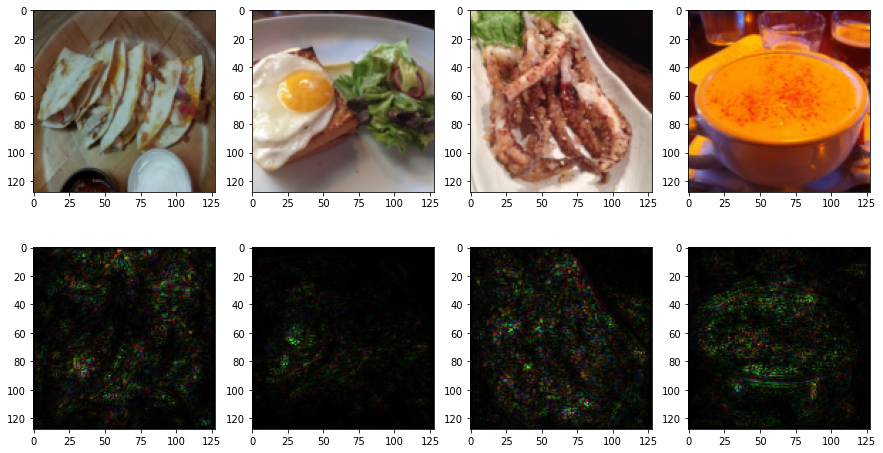

In [0]:
# 指定想要一起 visualize 的圖片 indices
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 使用 matplotlib 畫出來
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # 小知識：permute 是什麼，為什麼這邊要用?
    # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
    # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
    # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
    # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
    # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
    # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
    # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

plt.show()
plt.close()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

## Filter explaination

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

In [0]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
  # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
  # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
  # 也有某層 cnn 的 activation map
  # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
  # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

  # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
  model(x.cuda())
  # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  
  # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來
  # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor
  
  # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
  x = x.cuda()
  # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
  x.requires_grad_()
  # 我們要對 input image 算偏微分
  optimizer = Adam([x], lr=lr)
  # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # 與上一個作業不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
    # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
    # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization
    
    objective.backward()
    # 計算 filter activation 對 input image 的偏微分
    optimizer.step()
    # 修改 input image 來最大化 filter activation
  filter_visualization = x.detach().cpu().squeeze()[0]
  # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

  hook_handle.remove()
  # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
  # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
  # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

  return filter_activations, filter_visualization

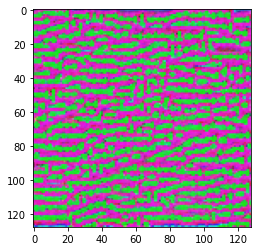

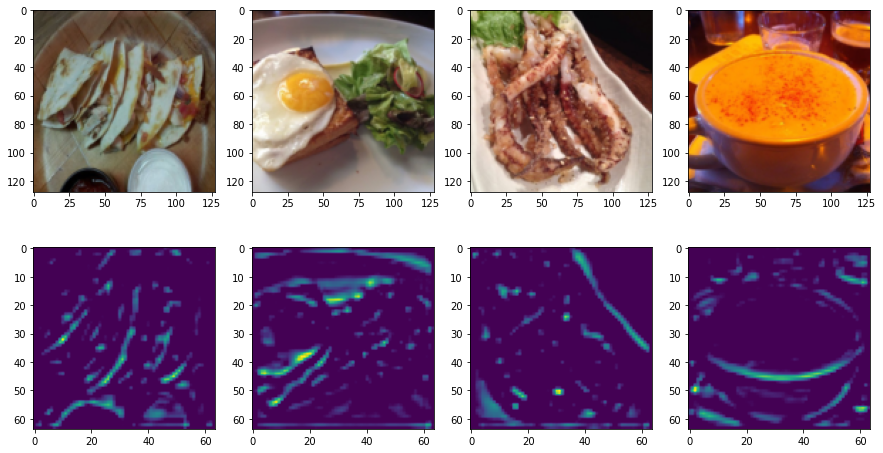

In [0]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

## Lime

Lime 的部分因為有現成的套件可以使用，因此下方直接 demo 如何使用該套件。其實非常的簡單，只需要 implement 兩個 function 即可。

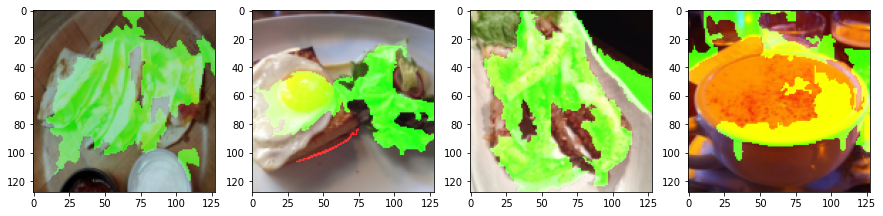

In [0]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。